In [12]:
import os
import glob
import random

train_path = "/kaggle/input/gender-classification-dataset/Training"
test_path = "/kaggle/input/gender-classification-dataset/validation"

train_images = [f for f in glob.glob(r'/kaggle/input/gender-classification-dataset/Training' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(train_images)
test_images = [f for f in glob.glob(r'/kaggle/input/gender-classification-dataset/Validation' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(test_images)

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array

In [14]:
req_dim = (24,24,3)
train_data = []
test_data = []
train_labels = []
test_labels = []
epochs = 100
lr = 1e-3
batch_size = 256

In [15]:
import cv2
for img in train_images:
    image = cv2.imread(img)
    image = cv2.resize(image,(req_dim[0],req_dim[1]))
    image = img_to_array(image)
    train_data.append(image)
    
    # In path 
    label = img.split(os.path.sep)[-2]
    if label == "female":
        label = 1
    else:
        label = 0
        
    train_labels.append(label)

In [16]:
for img in test_images:
    image = cv2.imread(img)
    image = cv2.resize(image,(req_dim[0],req_dim[1]))
    image = img_to_array(image)
    test_data.append(image)
    
    # In path 
    label = img.split(os.path.sep)[-2]
    if label == "female":
        label = 1
    else:
        label = 0
        
    test_labels.append(label)

In [17]:
import numpy as np
from tensorflow.keras.utils import to_categorical

trainX = np.array(train_data,dtype="float")/255.0
testX = np.array(test_data,dtype="float")/255.0

trainY = np.array(train_labels)
testY = np.array(test_labels)
trainY = to_categorical(trainY,num_classes=2)
testY = to_categorical(testY,num_classes=2)

In [18]:
#augumenting dataset
aug = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [20]:
def build(width, height, depth, classes):
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))


    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

In [21]:
# build model
model = build(width=req_dim[0], height=req_dim[1], depth=req_dim[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/183 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.5104 - loss: 1.0996 

W0000 00:00:1714489942.426082     780 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/183 ━━━━━━━━━━━━━━━━━━━━ 1:01 384ms/step - accuracy: 0.6175 - loss: 0.9957

W0000 00:00:1714489950.376557     778 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7218 - loss: 0.7034

W0000 00:00:1714489969.632670     779 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.7225 - loss: 0.7016 - val_accuracy: 0.4986 - val_loss: 1.2224
Epoch 2/100
  1/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8477 - loss: 0.3797

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8477 - loss: 0.3797 - val_accuracy: 0.4986 - val_loss: 1.1991
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.8615 - loss: 0.3385 - val_accuracy: 0.5714 - val_loss: 0.8757
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8906 - loss: 0.3107 - val_accuracy: 0.5916 - val_loss: 0.8028
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.8896 - loss: 0.2748 - val_accuracy: 0.9067 - val_loss: 0.2332
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8750 - loss: 0.3181 - val_accuracy: 0.9016 - val_loss: 0.2444
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.8974 - loss: 0.2567 - val_accuracy: 0.9372 - val_loss: 0.1708
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2249 - val_accuracy: 0.9354 - val_loss: 0.1754
Epoch 9/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9096 - loss: 0.2330 - val_accu

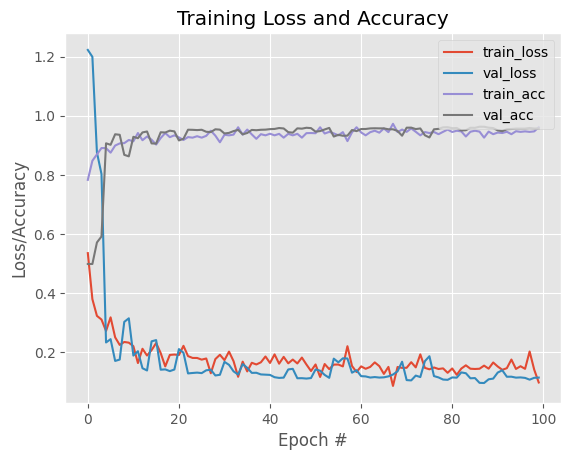

In [24]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")